In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")
_set_env("HF_TOKEN")

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [3]:
#%pip install -qU duckduckgo-search langchain-community
#%pip install -qU langchain_community wikipedia

In [4]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("Obama's first name?")

c:\Users\sumit\VSCodeProjects\LangGraph\venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'1 day ago · Barack Obama, the 44th President of the United States, broke barriers as the first African-American president and implemented significant healthcare reforms during his tenure. 2 days ago · For example, George Washington served two consecutive terms and is counted as the first president, instead of the first and second, but Grover Cleveland and Donald Trump are … Jun 17, 2025 · Barack Obama, the 44th President of the United States, was born in Hawaii and became the first president born outside the continental U.S. He achieved numerous milestones in … 3 days ago · The name "Obama" is of African origin, specifically from the Luo ethnic group in Kenya. It is derived from the Luo word "Obama," which means "to lean or bend." One of the most famous … Nov 4, 2024 · Obama was born in Honolulu, Hawaii. After graduating from Columbia University in 1983, he worked as a community organizer in Chicago. In 1988, he enrolled in Harvard Law …'

In [6]:
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from IPython.display import Image, display

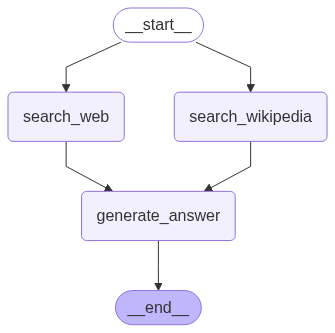

In [13]:
def search_web(state):
    """Retrive docs from web search"""

    duck_search = DuckDuckGoSearchRun()

    # 2. Invoke the search tool
    search_docs = duck_search.invoke(state['question'])

    # 3. Now, search_docs will be a list of dictionaries, and your list comprehension will work
    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'Document href="{doc["link"]}"/>\n{doc["snippet"]}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )

    # 4. Return the formatted context
    return {"context": [search_docs]}

def search_wikipedia(state):
    """Retrieve docs from wikipedia"""

    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()
    
    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page","")}"/>\n{doc.page_content}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )

    return {"context":[search_docs]}

def generate_answer(state):
    """Node to answer a question"""

    context = state["context"]
    question = state["question"]

    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    answer = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Answer the question")])

    return {"answer": answer}

builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
result = graph.invoke({"question":"What are expections for Nvidia Q2 2025 earnings?"})
result

c:\Users\sumit\VSCodeProjects\LangGraph\venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'question': 'What are expections for Nvidia Q2 2025 earnings?',
 'answer': AIMessage(content="Here's what the provided information suggests about expectations for Nvidia's Q2 2025 earnings:\n\n*   **Revenue:** Expected to be $32.5 billion, plus or minus 2%.\n*   **Gross Margins:** GAAP gross margins are expected to be 74.4%, and non-GAAP gross margins are expected to be 75.0%, plus or minus 50 basis points.\n*   **Key Figure to Watch:** Data center revenue will be a key figure to watch.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--16e0591e-755a-4db3-9fc2-2fa6e9b6bb3f-0', usage_metadata={'input_tokens': 3224, 'output_tokens': 114, 'total_tokens': 3338, 'input_token_details': {'cache_read': 0}}),
 'context': ['Aug 28, 2024 · Revenue is expected to be $32.5 billion, plus or minus 2%. GAAP and non-GAAP gross margins are expected to be 74.4%